[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pachterlab/OP_2025/blob/main/analysis_scripts/DEseq.ipynb)

# Clone github repo

In [ ]:
!git clone https://github.com/pachterlab/OP_2025.git
%cd /content/OP_2025/

# Download Data

In [ ]:
!mkdir omics_adata
!wget -P omics_adata https://data.caltech.edu/records/j57wp-0pp06/files/rat_RNA_transcript_meta.h5ad?download=1
!mv omics_adata/rat_RNA_transcript_meta.h5ad?download=1 omics_adata/rat_RNA_transcript_meta.h5ad
!wget -P omics_adata https://data.caltech.edu/records/j57wp-0pp06/files/rat_RNA_meta.h5ad?download=1
!mv omics_adata/rat_RNA_meta.h5ad?download=1 omics_adata/rat_RNA_meta.h5ad


# Install Packages

In [ ]:
!pip install -qr requirements.txt 

In [ ]:
# import packages

import os, sys
sys.path.append('analysis_scripts')
from pathlib import Path

import time

# numbers
import numpy as np
import pandas as pd
import scipy

# sc
import anndata
import scanpy as sc

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

import statsmodels.api as sm


# plots
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

from rat_friend import *


In [3]:
color_dict = {'male': '#E07F80',
            'female': '#317EC2',
              'transcript':'#E0AFCA',
              'gene':'#8D3666',
              'Other' : '#d8dcd6'
}

color_opts =  np.array([
    "#D55E00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#E69F00", "#CC79A7", "#666666", "#AD7700", "#1C91D4", "#007756", "#D5C711", "#005685",
    "#A04700", "#B14380", "#4D4D4D", "#FFBE2D", "#80C7EF", "#00F6B3", "#F4EB71", "#06A5FF", "#FF8320", "#D99BBD", "#8C8C8C", "#FFCB57", "#9AD2F2",
    "#2CFFC6", "#F6EF8E", "#38B7FF", "#FF9B4D", "#E0AFCA", "#A3A3A3", "#8A5F00", "#1674A9", "#005F45", "#AA9F0D", "#00446B", "#803800", "#8D3666",
    "#3D3D3D"
])
#8D3666, E0AFCA
tissues = ['ADRNL','BAT','BLOOD','COLON','CORTEX','HEART','HIPPOC','HYPOTH',
 'KIDNEY','LIVER', 'LUNG','OVARY','SKM-GN','SKM-VL','SMLINT','SPLEEN','TESTES','VENACV','WAT']
for x in range(len(tissues)):
    color_dict[tissues[x]] = color_opts[x]

color_dict

{'male': '#E07F80',
 'female': '#317EC2',
 'transcript': '#E0AFCA',
 'gene': '#8D3666',
 'Other': '#d8dcd6',
 'ADRNL': '#D55E00',
 'BAT': '#56B4E9',
 'BLOOD': '#009E73',
 'COLON': '#F0E442',
 'CORTEX': '#0072B2',
 'HEART': '#E69F00',
 'HIPPOC': '#CC79A7',
 'HYPOTH': '#666666',
 'KIDNEY': '#AD7700',
 'LIVER': '#1C91D4',
 'LUNG': '#007756',
 'OVARY': '#D5C711',
 'SKM-GN': '#005685',
 'SKM-VL': '#A04700',
 'SMLINT': '#B14380',
 'SPLEEN': '#4D4D4D',
 'TESTES': '#FFBE2D',
 'VENACV': '#80C7EF',
 'WAT': '#00F6B3'}

# Deseq Model Generation

## Load Transcript Data and Model

In [ ]:
og_adata = anndata.read_h5ad('omics_adata/rat_RNA_transcript_meta.h5ad')
og_adata.obs.time = og_adata.obs.time.astype('int')
og_adata.layers["counts"] = og_adata.X.copy()
adata = og_adata[:,og_adata.layers['counts'].sum(axis=0) > 10]

# remove tissues that cause problems for inference due to missing values
adata = adata[[x not in ['VENACV', 'TESTES', 'OVARY'] for x in adata.obs.tissue.values]]
transcripts = adata.var.gene_id.values
adata

View of AnnData object with n_obs × n_vars = 783 × 72010
    obs: 'barcode', 'path', 'nac_path', 'mat_path', 'amb_path', 'time', 'sex', 'tissue', 'viallabel', 'pid', 'calculated.variables.pct_body_fat_change', 'calculated.variables.pct_body_lean_change', 'calculated.variables.pct_body_fluid_change', 'calculated.variables.lactate_change_dueto_train', 'calculated.variables.vo2_max_change', 'calculated.variables.coll_time_train', 'calculated.variables.deathtime_after_train', 'calculated.variables.frozetime_after_train', 'group', 'rank', 'nid', 'num_umi', 'original_out', 'old_tissue'
    var: 'gene_id', 'has_U_tr', 'eff_len'
    uns: 'X_name'
    layers: 'ambiguous', 'spliced', 'unspliced', 'counts'

In [5]:
inference = DefaultInference()
transcript_dds = DeseqDataSet(
    counts=adata.layers['counts'],
    metadata=adata.obs[['nid', 'tissue', 'sex', 'time']],
    design = '~(tissue + sex) * (time)',
    inference=inference,
)
transcript_dds.deseq2()

Fitting size factors...
... done in 1.46 seconds.

/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pydeseq2/utils.py:379: RuntimeWarning: overflow encountered in exp
  mu_ = np.maximum(size_factors * np.exp(X @ beta), min_mu)
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/views.py:145: RuntimeWarning: invalid value encountered in multiply
  results = super().__array_ufunc__(
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pydeseq2/utils.py:231: RuntimeWarning: invalid value encountered in subtract
  -logbinom
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pydeseq2/utils.py:383: RuntimeWarning: overflow encountered in exp
  mu_ = np.maximum(size_factors * np.exp(X @ beta), min_mu)
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pydeseq2/utils.py:386: RuntimeWarning: invalid value encountered in divide
  + ((1 / disp + counts) * mu_ / (1 / disp + mu_)) @ X
/home/coakes/miniconda3/envs/rata/lib/pyth

## Load Gene Data and Model

In [6]:
og_adata = anndata.read_h5ad("omics_adata/rat_RNA_meta.h5ad")
og_adata.obs.time = og_adata.obs.time.astype('int')
og_adata.layers["counts"] = og_adata.X.copy()
adata = og_adata[:,og_adata.layers['counts'].sum(axis=0) > 10]
# remove tissues that cause problems for inference due to missing values
adata = adata[[x not in ['VENACV', 'TESTES', 'OVARY'] for x in adata.obs.tissue.values]]
genes = adata.var.gene_id.values
adata

View of AnnData object with n_obs × n_vars = 783 × 24762
    obs: 'barcode', 'path', 'nac_path', 'mat_path', 'amb_path', 'time', 'sex', 'tissue', 'viallabel', 'calculated.variables.pct_body_fat_change', 'calculated.variables.pct_body_lean_change', 'calculated.variables.pct_body_fluid_change', 'calculated.variables.lactate_change_dueto_train', 'calculated.variables.vo2_max_change', 'calculated.variables.coll_time_train', 'calculated.variables.deathtime_after_train', 'calculated.variables.frozetime_after_train', 'pid', 'group', 'rank', 'nid', 'num_umi', 'outlier', 'original_out', 'old_tissue'
    var: 'gene_id', 'has_U_tr', 'eff_len', 'mt', 'ensembl_transcript_id', 'description', 'ensembl_gene_id', 'X3', 'X5', 'X6', 'X7', 'X8'
    uns: 'X_name'
    layers: 'ambiguous', 'spliced', 'unspliced', 'counts'

In [7]:
inference = DefaultInference()
gene_dds = DeseqDataSet(
    counts=adata.layers['counts'],
    metadata=adata.obs[['nid', 'tissue', 'sex', 'time']],
    design = '~(tissue + sex) * (time)',
    inference=inference,
)
gene_dds.deseq2()

Fitting size factors...
... done in 0.58 seconds.

/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pydeseq2/utils.py:379: RuntimeWarning: overflow encountered in multiply
  mu_ = np.maximum(size_factors * np.exp(X @ beta), min_mu)
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pydeseq2/utils.py:383: RuntimeWarning: overflow encountered in multiply
  mu_ = np.maximum(size_factors * np.exp(X @ beta), min_mu)
Fitting dispersions...
... done in 12.95 seconds.

Fitting dispersion trend curve...
... done in 0.50 seconds.

Fitting MAP dispersions...
... done in 12.01 seconds.

Fitting LFCs...
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pydeseq2/utils.py:386: RuntimeWarning: overflow encountered in multiply
  + ((1 / disp + counts) * mu_ / (1 / disp + mu_)) @ X
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pydeseq2/utils.py:386: RuntimeWarning: invalid value encountered in matmul
  + ((1 / disp + counts) * mu_ / (1 / disp + mu_

## Statistical Tests (in SKM-GN tissue)

In [9]:
contrast_vector = contraster(transcript_dds.obs[['nid', 'tissue', 'sex', 'time']], '~(tissue + sex) * (time)',
          group1=[['tissue', 'SKM-GN'], ['time', 8]],
          group2=[['tissue', 'SKM-GN'], ['time', 0]])
contrast_vector

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       8., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 8., 0., 0., 0., 0., 4.])

In [10]:
stat_res_transcript = DeseqStats(transcript_dds, 
                                 contrast = contrast_vector,
                                 inference=inference)
stat_res_transcript.summary()
transcript_res = stat_res_transcript.results_df
transcript_res['gene_id'] = transcripts
transcript_res.sort_values(['padj'], ascending=True).iloc[0:25,:]

Running Wald tests...
... done in 4.50 seconds.



Log2 fold change & Wald test p-value, contrast vector: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 8. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 8. 0. 0. 0. 0. 4.]
         baseMean  log2FoldChange      lfcSE      stat    pvalue  padj
0        0.208095        0.221493   1.363032  0.162500  0.870912   NaN
1      907.026142       -0.007433   0.080118 -0.092778  0.926080   1.0
2      157.772603       -0.003808   0.147507 -0.025817  0.979403   1.0
3       13.480834       -0.408340   0.384872 -1.060978  0.288700   1.0
4       10.467944        0.076313   0.302752  0.252063  0.800992   1.0
...           ...             ...        ...       ...       ...   ...
72005   10.541612       -0.182462   1.008221 -0.180974  0.856388   1.0
72006    1.114098        0.163785   1.289658  0.126999  0.898941   NaN
72007    0.177731       -0.124754   1.594138 -0.078258  0.937623   NaN
72008    2.053803       -0.355585   1.452454 -0.244817  0.806598   NaN
72009    0.071702       -0.297791  16.201436 -0.018381  0.9

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_id
3463,61.817610,-583.319161,11.483029,-50.798372,0.000000e+00,0.000000e+00,ENSRNOT00000085775
40705,326.558106,-3.722176,0.436214,-8.532911,1.427108e-17,3.422776e-13,ENSRNOT00000084090
67218,194.172428,0.815885,0.099290,8.217185,2.083349e-16,3.331136e-12,ENSRNOG00000009431
61735,82.049856,-0.698532,0.092290,-7.568849,3.765462e-14,3.727577e-10,ENSRNOG00000012679
22189,129.592153,5.981590,0.790717,7.564771,3.885483e-14,3.727577e-10,ENSRNOT00000110235
61660,157.585109,-1.454506,0.200336,-7.260335,3.861333e-13,3.087007e-09,ENSRNOG00000022723
8883,216.199921,-3.587109,0.514288,-6.974905,3.060780e-12,2.097421e-08,ENSRNOT00000066501
27218,50.368513,-1.528162,0.226876,-6.735664,1.631832e-11,9.784466e-08,ENSRNOT00000037555
5156,222.417097,1.632654,0.251152,6.500672,7.996205e-11,3.737813e-07,ENSRNOT00000020272
56898,192.850301,2.196758,0.337764,6.503818,7.830661e-11,3.737813e-07,ENSRNOG00000011550


In [11]:
stat_res_gene = DeseqStats(gene_dds, 
                                 contrast = contrast_vector,
                           inference=inference)
stat_res_gene.summary()
gene_res = stat_res_gene.results_df
gene_res['gene_id'] = genes
gene_res.sort_values(['padj'], ascending=True).iloc[0:25,:]

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 8. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 8. 0. 0. 0. 0. 4.]
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0        18.458399       -0.028270  0.196644 -0.143760  0.885690  0.999064
1       568.277005        0.414520  0.237767  1.743390  0.081265  0.720132
2        42.168148       -0.023524  0.139358 -0.168803  0.865952  0.999064
3         1.013414        0.506764  1.083070  0.467896  0.639859       NaN
4       123.117689       -1.014548  0.752121 -1.348916  0.177364  0.872953
...            ...             ...       ...       ...       ...       ...
24757     3.256219       -0.024842  0.772291 -0.032167  0.974339  0.999064
24758     2.665649       -0.228195  0.501590 -0.454943  0.649150  0.999064
24759    63.267534        0.160349  0.180189  0.889894  0.373523  0.993879
24760   734.219984       -0.120846  0.080750 -1.496542  0.134512  0.827611
24761  1236.942

... done in 1.77 seconds.



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_id
2584,447.201292,0.687107,0.092815,7.402967,1.331751e-13,1.497983e-09,ENSRNOG00000005176
11321,207.087496,-1.463165,0.198083,-7.386630,1.505965e-13,1.497983e-09,ENSRNOG00000022723
8255,5834.362350,-0.727967,0.103084,-7.061881,1.642638e-12,1.089288e-08,ENSRNOG00000016516
3225,1048.578067,-0.454124,0.064994,-6.987144,2.805385e-12,1.116206e-08,ENSRNOG00000006689
6491,747.616850,-0.320922,0.045755,-7.013996,2.316061e-12,1.116206e-08,ENSRNOG00000013011
17883,405.354667,-1.595811,0.252611,-6.317257,2.662468e-10,8.827857e-07,ENSRNOG00000057996
5624,681.441644,0.704274,0.116982,6.020340,1.740507e-09,4.328206e-06,ENSRNOG00000011323
6314,238.692605,-0.367953,0.060994,-6.032580,1.613624e-09,4.328206e-06,ENSRNOG00000012679
8499,286.775882,-0.754548,0.128392,-5.876898,4.180265e-09,9.240245e-06,ENSRNOG00000016950
9803,247.945653,0.492312,0.084599,5.819386,5.906422e-09,1.175024e-05,ENSRNOG00000019318


## Attach Gene Metadata

In [ ]:
gene_meta = pd.read_csv('metadata_csvs/t2go.csv')
transcript_res = pd.merge(transcript_res, gene_meta, left_on= 'gene_id', right_on='ensembl_transcript_id', how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
gene_res = pd.merge(gene_res, gene_meta, left_on='gene_id', right_on='ensembl_gene_id', how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)').groupby('gene_id').first().reset_index().drop('ensembl_transcript_id', axis=1)

## Show Most Significant Gene Level Changes Over Time

In [13]:
gene_filtered = gene_res[(gene_res.padj < .05)]
old_genes = gene_filtered[genes_in_original(gene_filtered.gene_id.values, og_supp_table=4)]
new_genes = gene_filtered[[x not in old_genes.gene_id.values for x in gene_filtered.gene_id.values]]
print(gene_filtered.shape, old_genes.shape, new_genes.shape)

(142, 15) (2, 15) (140, 15)


In [14]:
old_genes.sort_values(['log2FoldChange'], ascending=False, key=abs).iloc[0:5,:]

,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,ensembl_gene_id,X3,X4,X5,X6,X7,X8,description
5219,ENSRNOG00000010574,1284.627799,-0.327906,0.060955,-5.379440,7.471807e-08,0.000099,ENSRNOG00000010574,Ptpn1,Ptpn1-201,3,156638769,156687504,+,"protein tyrosine phosphatase activity, cytopla..."
13322,ENSRNOG00000029866,307.975329,0.176738,0.048490,3.644877,2.675199e-04,0.045880,ENSRNOG00000029866,Dennd6b,Dennd6b-201,7,120261679,120273494,-,guanyl-nucleotide exchange factor activity


In [15]:
new_genes.sort_values(['log2FoldChange'], ascending=False, key=abs).iloc[15:25,:]

,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,ensembl_gene_id,X3,X4,X5,X6,X7,X8,description
5744,ENSRNOG00000011550,887.558550,1.245052,0.233065,5.342074,9.188938e-08,0.000114,ENSRNOG00000011550,Kcnab2,Kcnab2-201,5,162901896,162988243,-,"voltage-gated potassium channel activity, cyto..."
11878,ENSRNOG00000024688,27.771728,-1.236104,0.224512,-5.505739,3.676232e-08,0.000052,ENSRNOG00000024688,Erfe,Erfe-201,9,91956977,91964846,+,"hormone activity, protein binding, extracellul..."
9599,ENSRNOG00000018950,177.397867,-1.210617,0.280259,-4.319631,1.562900e-05,0.005866,ENSRNOG00000018950,Fa2h,Fa2h-201,19,39312906,39364153,-,"sebaceous gland cell differentiation, iron ion..."
22191,ENSRNOG00000067530,251.063282,-1.144835,0.319732,-3.580610,3.427926e-04,0.049975,ENSRNOG00000067530,LOC103691527,LOC103691527-201,2,117539737,117589148,+,None
15733,ENSRNOG00000046365,33.939329,1.136928,0.297643,3.819770,1.335764e-04,0.029526,ENSRNOG00000046365,Oit3,Oit3-201,20,27390113,27410692,-,"renal system process, calcium ion binding"
9568,ENSRNOG00000018895,35.242190,1.079962,0.297832,3.626078,2.877584e-04,0.046167,ENSRNOG00000018895,Mchr1,Mchr1-201,7,112761554,112764032,+,"G protein-coupled receptor activity, signaling..."
360,ENSRNOG00000000840,873.293008,1.071132,0.209056,5.123652,2.996739e-07,0.000314,ENSRNOG00000000840,Atp6v1g2,Atp6v1g2-201,20,3587686,3590481,-,vacuolar proton-transporting V-type ATPase com...
4596,ENSRNOG00000009345,185.897750,-1.021736,0.280130,-3.647364,2.649441e-04,0.045833,ENSRNOG00000009345,Ugt8,Ugt8-201,2,214264483,214332660,-,protein localization to paranode region of axo...
9643,ENSRNOG00000019024,57.000338,-1.018867,0.245609,-4.148326,3.349152e-05,0.010923,ENSRNOG00000019024,Trim67,Trim67-201,19,52764387,52800422,+,"protein binding, cytoplasm, zinc ion binding, ..."
11762,ENSRNOG00000024310,120.258963,1.017894,0.282593,3.601981,3.158020e-04,0.048112,ENSRNOG00000024310,Kcnf1,Kcnf1-201,6,39962307,39964979,-,"monoatomic ion channel activity, voltage-gated..."


## Plot Top Genes of Interest Over Time

In [16]:
goi = ['ENSRNOG00000000840', 'ENSRNOG00000029866'] 
toi = 'SKM-GN'
og_adata = anndata.read_h5ad("omics_adata/rat_RNA_meta.h5ad")
og_adata.obs.time = og_adata.obs.time.astype('int')
og_adata.layers["counts"] = og_adata.X.copy()
small_gene_adata = og_adata[:,og_adata.var.gene_id.isin(goi)]
#small_gene_adata.var.head()

In [17]:
summary_df = pd.DataFrame(small_gene_adata.layers['counts'])
summary_df.columns = small_gene_adata.var.X3.values
summary_df['time'] = small_gene_adata.obs.time.values
summary_df['tissue'] = small_gene_adata.obs.tissue.values
summary_df['sex'] = small_gene_adata.obs.sex.values
summary_df = pd.melt(summary_df, ['time', 'tissue', 'sex'], var_name = 'gene', value_name = 'gene_count')
summary_df.head()

,time,tissue,sex,gene,gene_count
0,1,SKM-GN,female,Atp6v1g2,2.0
1,4,SKM-GN,male,Atp6v1g2,13.0
2,4,SKM-GN,male,Atp6v1g2,7.0
3,1,SKM-GN,female,Atp6v1g2,1.0
4,0,SKM-GN,female,Atp6v1g2,6.0


/tmp/ipykernel_2089718/3358937644.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df.loc[:,'jiggle_time'] = small_df.time + .25-.5*np.random.random(size = len(small_df.time.values))


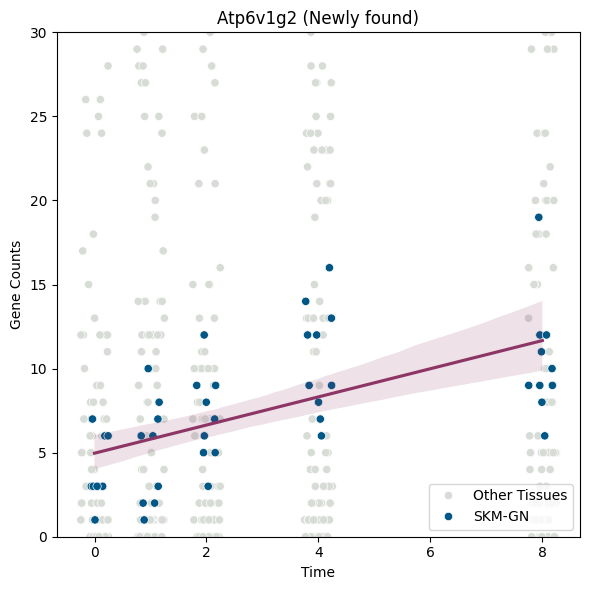

In [18]:
curr_goi = small_gene_adata.var.X3.values[0]
small_df = summary_df[summary_df.gene == curr_goi]
small_df.loc[:,'tissue'] = small_df.tissue == toi
small_df.loc[:,'tissue'] = [toi if x else 'Other' for x in small_df.tissue.values]
small_df.loc[:,'jiggle_time'] = small_df.time + .25-.5*np.random.random(size = len(small_df.time.values))

plt.figure(figsize=(6, 6))
g = sns.scatterplot(
        data=small_df.sort_values('tissue'), x='jiggle_time', y='gene_count',
    hue = 'tissue',
    palette = color_dict,
        )
sns.regplot(
        data=small_df[small_df.tissue.isin([toi])], x='time', y='gene_count',
    color = color_dict['gene'],scatter=False
)
handles, labels  =  g.get_legend_handles_labels()

g.legend(handles, ['Other Tissues', toi], loc='lower right')
plt.xlabel('Time')
plt.ylabel('Gene Counts')
plt.ylim([0, 30])
plt.title(f'{curr_goi} (Newly found)')
plt.tight_layout()
plt.savefig('figures_final/fig_2a.png')
plt.show()

/tmp/ipykernel_2089718/3792467076.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df.loc[:,'jiggle_time'] = small_df.time + .25-.5*np.random.random(size = len(small_df.time.values))


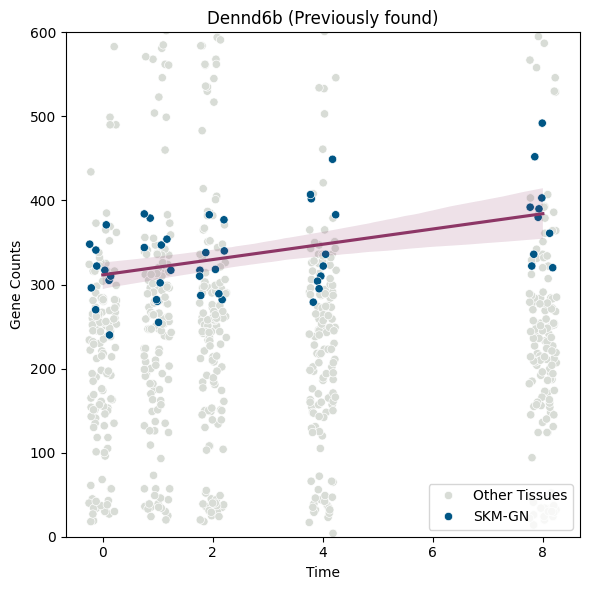

In [19]:
curr_goi = small_gene_adata.var.X3.values[1]
small_df = summary_df[summary_df.gene == curr_goi]
small_df.loc[:,'tissue'] = small_df.tissue == toi
small_df.loc[:,'tissue'] = [toi if x else 'Other' for x in small_df.tissue.values]
small_df.loc[:,'jiggle_time'] = small_df.time + .25-.5*np.random.random(size = len(small_df.time.values))

plt.figure(figsize=(6, 6))
g = sns.scatterplot(
        data=small_df.sort_values('tissue'), x='jiggle_time', y='gene_count',
    hue = 'tissue',
    palette = color_dict,
        )
sns.regplot(
        data=small_df[small_df.tissue.isin([toi])], x='time', y='gene_count',
    color = color_dict['gene'],scatter=False
)
handles, labels  =  g.get_legend_handles_labels()

g.legend(handles, ['Other Tissues', toi], loc='lower right')
plt.xlabel('Time')
plt.ylabel('Gene Counts')
#plt.yscale('log', base=2)
plt.ylim([0, 600])
plt.title(f'{curr_goi} (Previously found)')
plt.tight_layout()
plt.savefig('figures_final/fig_2b.png')
plt.show()

# Isoform vs Gene Level P-Values

In [31]:
t2_full = transcript_res[['baseMean', 'log2FoldChange', 'padj', 'ensembl_transcript_id', 'ensembl_gene_id', 'X3']]
t2_full = t2_full.groupby(['ensembl_gene_id', 'X3'])[['baseMean', 'log2FoldChange', 'padj', 'ensembl_transcript_id']].agg(lambda x: list(x))
t2_small = t2_full.apply(lambda x: lancaster(x.padj, np.log(x.baseMean/np.min(x.baseMean))+1), axis=1).reset_index()
t2_small.columns = ['ensembl_gene_id', 'X3', 'lancaster']
t2_full = pd.merge(t2_full, t2_small, on=['ensembl_gene_id', 'X3'], how='left', suffixes=('', '_transcript'))

/tmp/ipykernel_2079234/4050584871.py:3: RuntimeWarning: divide by zero encountered in divide
  t2_small = t2_full.apply(lambda x: lancaster(x.padj, np.log(x.baseMean/np.min(x.baseMean))+1), axis=1).reset_index()
/tmp/ipykernel_2079234/4050584871.py:3: RuntimeWarning: invalid value encountered in divide
  t2_small = t2_full.apply(lambda x: lancaster(x.padj, np.log(x.baseMean/np.min(x.baseMean))+1), axis=1).reset_index()


In [32]:
big_comp = pd.merge(gene_res, t2_full, on='ensembl_gene_id', how='left', suffixes=('', '_transcript'))
big_comp['pval_diff'] = big_comp.padj-big_comp.lancaster
big_comp['LFC'] = np.abs(big_comp.log2FoldChange)
big_comp.head()

,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,ensembl_gene_id,X3,X4,...,X8,description,X3_transcript,baseMean_transcript,log2FoldChange_transcript,padj_transcript,ensembl_transcript_id,lancaster,pval_diff,LFC
0,ENSRNOG00000000001,18.458399,-0.028270,0.196644,-0.143760,0.885690,0.999064,ENSRNOG00000000001,Arsj,Arsj-201,...,+,"sulfuric ester hydrolase activity, actin cytos...",Arsj,"[13.739765293189658, 4.607977394036107]","[0.011680483081031152, -0.16974770638762915]","[1.0, nan]","[ENSRNOT00000055633, ENSRNOG00000000001]",1.000000,-0.000936,0.028270
1,ENSRNOG00000000007,568.277005,0.414520,0.237767,1.743390,0.081265,0.720132,ENSRNOG00000000007,Gad1,Gad1-201,...,+,"catalytic activity, glutamate decarboxylase ac...",Gad1,"[421.92382548804363, 0.2675234462717402, 101.0...","[-0.8749552796997994, 0.7985710903011006, 0.55...","[1.0, nan, 0.9527153768441079, 1.0]","[ENSRNOT00000000008, ENSRNOT00000084375, ENSRN...",1.000000,-0.279868,0.414520
2,ENSRNOG00000000008,42.168148,-0.023524,0.139358,-0.168803,0.865952,0.999064,ENSRNOG00000000008,Alx4,Alx4-201,...,+,RNA polymerase II transcription regulatory reg...,Alx4,"[7.546527924100162, 0.8425167790320742, 34.144...","[-0.2551332543949837, 0.21456391034444927, 0.0...","[nan, nan, 1.0]","[ENSRNOT00000000009, ENSRNOT00000114813, ENSRN...",1.000000,-0.000936,0.023524
3,ENSRNOG00000000009,1.013414,0.506764,1.083070,0.467896,0.639859,NaN,ENSRNOG00000000009,Tmco5b,Tmco5b-201,...,+,None,Tmco5b,"[0.19831249459482292, 0.793670997665745]","[-0.009338314183807796, 0.39461599695883776]","[nan, nan]","[ENSRNOT00000000010, ENSRNOG00000000009]",NaN,NaN,0.506764
4,ENSRNOG00000000010,123.117689,-1.014548,0.752121,-1.348916,0.177364,0.872953,ENSRNOG00000000010,Cbln1,Cbln1-201,...,+,"protein binding, extracellular region, heterop...",Cbln1,"[116.67087430596739, 3.5156165389995757]","[-0.9515374948601265, -0.2978772904868517]","[0.9684822695532952, nan]","[ENSRNOT00000000011, ENSRNOG00000000010]",0.968482,-0.095529,1.014548


In [33]:
toi_means = np.sum(og_adata[og_adata.obs.tissue == toi].layers['counts'], axis=0)
big_comp = pd.merge(big_comp, pd.DataFrame({'ensembl_gene_id':og_adata.var.ensembl_gene_id,
                                f'{toi}_means':toi_means}), on='ensembl_gene_id')
big_comp.head()

,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,ensembl_gene_id,X3,X4,...,description,X3_transcript,baseMean_transcript,log2FoldChange_transcript,padj_transcript,ensembl_transcript_id,lancaster,pval_diff,LFC,SKM-GN_means
0,ENSRNOG00000000001,18.458399,-0.028270,0.196644,-0.143760,0.885690,0.999064,ENSRNOG00000000001,Arsj,Arsj-201,...,"sulfuric ester hydrolase activity, actin cytos...",Arsj,"[13.739765293189658, 4.607977394036107]","[0.011680483081031152, -0.16974770638762915]","[1.0, nan]","[ENSRNOT00000055633, ENSRNOG00000000001]",1.000000,-0.000936,0.028270,602.0
1,ENSRNOG00000000007,568.277005,0.414520,0.237767,1.743390,0.081265,0.720132,ENSRNOG00000000007,Gad1,Gad1-201,...,"catalytic activity, glutamate decarboxylase ac...",Gad1,"[421.92382548804363, 0.2675234462717402, 101.0...","[-0.8749552796997994, 0.7985710903011006, 0.55...","[1.0, nan, 0.9527153768441079, 1.0]","[ENSRNOT00000000008, ENSRNOT00000084375, ENSRN...",1.000000,-0.279868,0.414520,302.0
2,ENSRNOG00000000008,42.168148,-0.023524,0.139358,-0.168803,0.865952,0.999064,ENSRNOG00000000008,Alx4,Alx4-201,...,RNA polymerase II transcription regulatory reg...,Alx4,"[7.546527924100162, 0.8425167790320742, 34.144...","[-0.2551332543949837, 0.21456391034444927, 0.0...","[nan, nan, 1.0]","[ENSRNOT00000000009, ENSRNOT00000114813, ENSRN...",1.000000,-0.000936,0.023524,3565.0
3,ENSRNOG00000000009,1.013414,0.506764,1.083070,0.467896,0.639859,NaN,ENSRNOG00000000009,Tmco5b,Tmco5b-201,...,None,Tmco5b,"[0.19831249459482292, 0.793670997665745]","[-0.009338314183807796, 0.39461599695883776]","[nan, nan]","[ENSRNOT00000000010, ENSRNOG00000000009]",NaN,NaN,0.506764,9.0
4,ENSRNOG00000000010,123.117689,-1.014548,0.752121,-1.348916,0.177364,0.872953,ENSRNOG00000000010,Cbln1,Cbln1-201,...,"protein binding, extracellular region, heterop...",Cbln1,"[116.67087430596739, 3.5156165389995757]","[-0.9515374948601265, -0.2978772904868517]","[0.9684822695532952, nan]","[ENSRNOT00000000011, ENSRNOG00000000010]",0.968482,-0.095529,1.014548,42.0


In [34]:
big_comp[(big_comp.lancaster <.05) & (big_comp.padj > .05)].sort_values(['log2FoldChange'], ascending=False, key=abs)

,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,ensembl_gene_id,X3,X4,...,description,X3_transcript,baseMean_transcript,log2FoldChange_transcript,padj_transcript,ensembl_transcript_id,lancaster,pval_diff,LFC,SKM-GN_means
11980,ENSRNOG00000025040,61.392614,1.421814,0.540567,2.630225,0.008533,0.331363,ENSRNOG00000025040,Gng10,Gng10-201,...,None,Gng10,"[45.66481504557833, 13.434748220468865]","[3.7405778063571806, -0.49168135106480454]","[0.0074411867211702796, 1.0]","[ENSRNOT00000020707, ENSRNOG00000025040]",0.019502,0.311861,1.421814,230.0
23186,ENSRNOG00000068984,726.408575,0.624946,0.231150,2.703631,0.006859,0.294699,ENSRNOG00000068984,Gbp1,Gbp1-201,...,"GTPase activity, GTP binding",Gbp1,"[705.4438642753337, 57.6082753287073]","[0.6046111132831099, 0.9670071402978907]","[0.41229858516978024, 0.005391897190140609]","[ENSRNOT00000094466, ENSRNOG00000068984]",0.035312,0.259387,0.624946,22429.0
6128,ENSRNOG00000012303,1200.641868,-0.420694,0.337444,-1.246707,0.212505,0.907548,ENSRNOG00000012303,Apobec2,Apobec2-201,...,catalytic activity,Apobec2,"[1234.0795271883123, 72.6139490552219]","[-0.3769356205898067, -1.0492194578782492]","[1.0, 3.7378134906662483e-07]","[ENSRNOT00000016893, ENSRNOG00000012303]",0.000082,0.907466,0.420694,314135.0
10251,ENSRNOG00000020138,858.550252,-0.337101,0.095808,-3.518514,0.000434,0.058778,ENSRNOG00000020138,Slc4a3,Slc4a3-201,...,"solute:inorganic anion antiporter activity, pl...",Slc4a3,"[706.4581233404674, 156.25633547348045]","[-0.28386790453802385, -0.460745040723552]","[0.20429888509187363, 0.022410400780160506]","[ENSRNOT00000027337, ENSRNOG00000020138]",0.041337,0.017441,0.337101,22053.0
7315,ENSRNOG00000014624,366.253632,-0.188841,0.056695,-3.330797,0.000866,0.092127,ENSRNOG00000014624,Selenok,Selenok-201,...,"endoplasmic reticulum membrane, membrane",Selenok,"[295.700851708844, 58.72775042436384]","[-0.10924466281032644, -0.6061118443600892]","[0.8275088483543885, 3.415646953558533e-06]","[ENSRNOT00000020284, ENSRNOG00000014624]",0.000119,0.092008,0.188841,17969.0
12473,ENSRNOG00000026793,1158.529286,-0.153261,0.090935,-1.685386,0.091914,0.750989,ENSRNOG00000026793,Nt5dc3,Nt5dc3-201,...,"cytosol, receptor complex",Nt5dc3,"[1107.2261392235164, 77.84093925070349]","[-0.12778817175385992, -0.5342018687732916]","[0.9674836861469593, 0.00028116002045708364]","[ENSRNOT00000031871, ENSRNOG00000026793]",0.014175,0.736814,0.153261,99538.0
5323,ENSRNOG00000010765,2620.545220,0.145639,0.075751,1.922608,0.054529,0.662275,ENSRNOG00000010765,Vcl,Vcl-201,...,"morphogenesis of an epithelium, podosome, dyst...",Vcl,"[1784.9480234549796, 528.9185083131595, 361.15...","[0.3659674183300886, 0.004648353213480807, 0.1...","[0.00020447865485188676, 1.0, 1.0]","[ENSRNOT00000015179, ENSRNOT00000085126, ENSRN...",0.002244,0.660030,0.145639,183437.0
8030,ENSRNOG00000016133,839.978124,-0.143015,0.050950,-2.806953,0.005001,0.254341,ENSRNOG00000016133,Sumo1,Sumo1-201,...,"NA, protein binding",Sumo1,"[442.84492243617075, 32.10883264922908, 192.25...","[-0.05182771385238663, -0.45276503833516846, -...","[1.0, 1.0, 0.3515877394275972, 1.0, 0.00028116...","[ENSRNOT00000022047, ENSRNOT00000108699, ENSRN...",0.039662,0.214680,0.143015,31350.0
6113,ENSRNOG00000012274,1481.079812,0.134802,0.060359,2.233345,0.025526,0.513616,ENSRNOG00000012274,Ddi2,Ddi2-201,...,"aspartic-type endopeptidase activity, protein ...",Ddi2,"[357.30273908809176, 263.8855293572512, 597.61...","[1.1075527763558648, -0.09121056453321329, 0.1...","[7.758777634665594e-06, 1.0, 0.967483686146959...","[ENSRNOT00000016352, ENSRNOT00000109253, ENSRN...",0.000797,0.512819,0.134802,60898.0
19618,ENSRNOG00000063815,136.971518,-0.128021,2.771711,-0.046188,0.963160,0.999064,ENSRNOG00000063815,Sult2a2-ps1,Sult2a2-ps1-201,...,sulfotransferase activity,Sult2a2-ps1,"[66.68683601271805, 61.81760970454749, 10.3627...","[-0.12475190819321706, -583.3191611520158, -40...","[1.0, 0.0, 1.0]","[ENSRNOT00000064593, ENSRNOT00000085775, ENSRN...",0.000000,0.999064,0.128021

signficant with lancaster only: 18
signficant with genes only: 82
signficant with both: 43


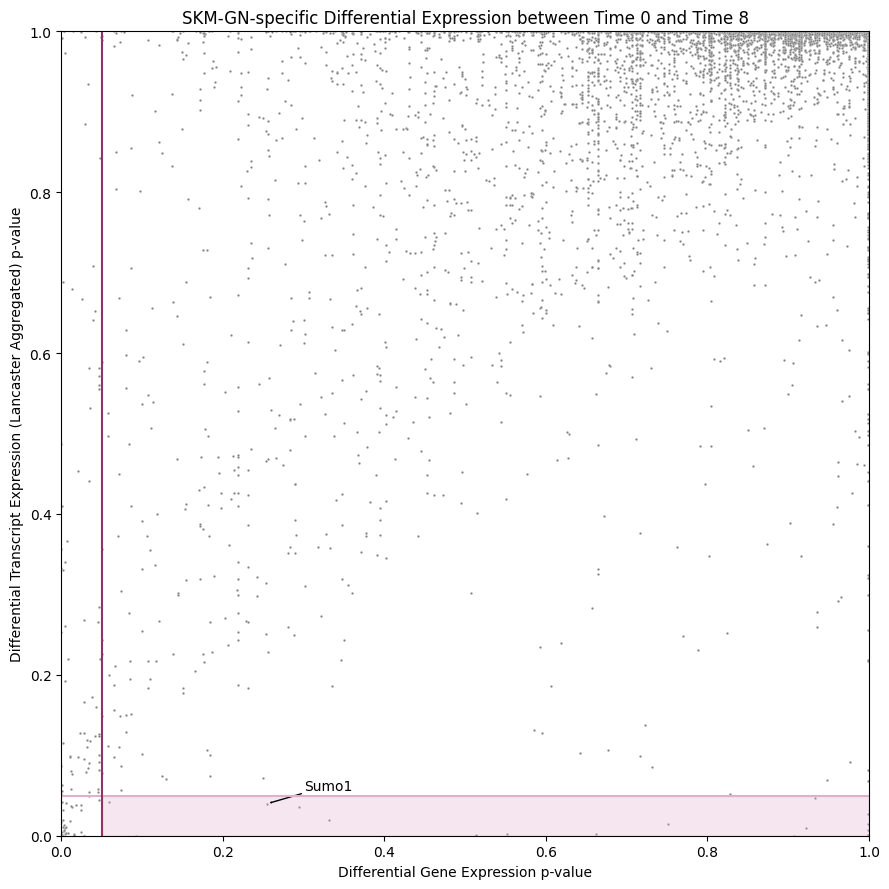

In [ ]:
print('signficant with lancaster only:', np.sum((big_comp.lancaster <.05) & (big_comp.padj > .05)))
print('signficant with genes only:', np.sum((big_comp.padj <.05) & (big_comp.lancaster > .05)))
print('signficant with both:', np.sum((big_comp.lancaster <.05) & (big_comp.padj < .05)))
goi = 'ENSRNOG00000016133'
fig, ax = plt.subplots(figsize=(9, 9))
sns.scatterplot(big_comp, y = 'lancaster', x = 'padj', 
                #hue='log2FoldChange', 
                s = 3, c = 'grey')#, alpha=1)
plt.axvspan(ymin = 0, ymax = .05, xmin = .05, xmax=1,color=color_dict['transcript'], alpha = .3)
texts = [plt.text(x=big_comp.loc[big_comp.gene_id==goi, 'padj'], y=big_comp.loc[big_comp.gene_id==goi, 'lancaster'], 
         s=big_comp.loc[big_comp.gene_id==goi, 'X3'].values[0])]
adjust_text(texts, expand=(2, 2),
            target_y = big_comp.loc[big_comp.gene_id==goi, 'lancaster'],
            arrowprops=dict(arrowstyle="->", color='black'))
plt.plot([0, 1], [.05, .05], c=color_dict['transcript'])
plt.plot([.05, .05], [0, 1], c=color_dict['gene'])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Differential Transcript Expression (Lancaster Aggregated) p-value')
plt.xlabel('Differential Gene Expression p-value')
plt.title('SKM-GN-specific Differential Expression between Time 0 and Time 8')
plt.tight_layout()
plt.savefig(f'figures_final/fig_2c.png')
plt.show()

# Isoform Level Significance, no Gene Level Significance

In [38]:
big_comp[big_comp.ensembl_gene_id == goi]

,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,ensembl_gene_id,X3,X4,...,description,X3_transcript,baseMean_transcript,log2FoldChange_transcript,padj_transcript,ensembl_transcript_id,lancaster,pval_diff,LFC,SKM-GN_means
8030,ENSRNOG00000016133,839.978124,-0.143015,0.05095,-2.806953,0.005001,0.254341,ENSRNOG00000016133,Sumo1,Sumo1-201,...,"NA, protein binding",Sumo1,"[442.84492243617075, 32.10883264922908, 192.25...","[-0.05182771385238663, -0.45276503833516846, -...","[1.0, 1.0, 0.3515877394275972, 1.0, 0.00028116...","[ENSRNOT00000022047, ENSRNOT00000108699, ENSRN...",0.039662,0.21468,0.143015,31350.0


## Reload Transcript Level Data for this Gene

In [39]:
og_adata = anndata.read_h5ad('omics_adata/rat_RNA_transcript_meta.h5ad')
og_adata.obs.time = og_adata.obs.time.astype('int')
og_adata.layers["counts"] = og_adata.X.copy()
small_transcript_adata = og_adata[:,og_adata.var.ensembl_gene_id == goi]
small_transcript_adata

View of AnnData object with n_obs × n_vars = 861 × 5
    obs: 'barcode', 'path', 'nac_path', 'mat_path', 'amb_path', 'time', 'sex', 'tissue', 'viallabel', 'calculated.variables.pct_body_fat_change', 'calculated.variables.pct_body_lean_change', 'calculated.variables.pct_body_fluid_change', 'calculated.variables.lactate_change_dueto_train', 'calculated.variables.vo2_max_change', 'calculated.variables.coll_time_train', 'calculated.variables.deathtime_after_train', 'calculated.variables.frozetime_after_train', 'pid', 'nid', 'old_tissue'
    var: 'gene_id', 'has_U_tr', 'eff_len', 'ensembl_transcript_id', 'ensembl_gene_id', 'X3', 'X5', 'X6', 'X7', 'X8', 'description', 'n_counts'
    uns: 'X_name'
    layers: 'ambiguous', 'spliced', 'unspliced', 'counts'

## Reload Gene Level Data for this Gene

In [40]:
og_adata = anndata.read_h5ad("omics_adata/rat_RNA_meta.h5ad")
og_adata.obs.time = og_adata.obs.time.astype('int')
og_adata.layers["counts"] = og_adata.X.copy()
small_gene_adata = og_adata[:,og_adata.var.gene_id == goi]
small_gene_adata

View of AnnData object with n_obs × n_vars = 861 × 1
    obs: 'barcode', 'path', 'nac_path', 'mat_path', 'amb_path', 'time', 'sex', 'tissue', 'viallabel', 'calculated.variables.pct_body_fat_change', 'calculated.variables.pct_body_lean_change', 'calculated.variables.pct_body_fluid_change', 'calculated.variables.lactate_change_dueto_train', 'calculated.variables.vo2_max_change', 'calculated.variables.coll_time_train', 'calculated.variables.deathtime_after_train', 'calculated.variables.frozetime_after_train', 'pid', 'group', 'rank', 'nid', 'num_umi', 'outlier', 'original_out', 'old_tissue'
    var: 'gene_id', 'has_U_tr', 'eff_len', 'mt', 'ensembl_transcript_id', 'description', 'ensembl_gene_id', 'X3', 'X5', 'X6', 'X7', 'X8'
    uns: 'X_name'
    layers: 'ambiguous', 'spliced', 'unspliced', 'counts'

In [41]:
goi_df = big_comp[big_comp.ensembl_gene_id == goi]
goi_df

,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,ensembl_gene_id,X3,X4,...,description,X3_transcript,baseMean_transcript,log2FoldChange_transcript,padj_transcript,ensembl_transcript_id,lancaster,pval_diff,LFC,SKM-GN_means
8030,ENSRNOG00000016133,839.978124,-0.143015,0.05095,-2.806953,0.005001,0.254341,ENSRNOG00000016133,Sumo1,Sumo1-201,...,"NA, protein binding",Sumo1,"[442.84492243617075, 32.10883264922908, 192.25...","[-0.05182771385238663, -0.45276503833516846, -...","[1.0, 1.0, 0.3515877394275972, 1.0, 0.00028116...","[ENSRNOT00000022047, ENSRNOT00000108699, ENSRN...",0.039662,0.21468,0.143015,31350.0


## Summarize per-Tissue Expression

In [42]:
summary_df = pd.DataFrame(small_transcript_adata.layers['counts'])
summary_df.columns = small_transcript_adata.var.ensembl_transcript_id.values
summary_df['Sum'] = small_gene_adata.layers['counts'][:,0]
summary_df['time'] = small_transcript_adata.obs.time.values
summary_df['tissue'] = small_transcript_adata.obs.tissue.values
summary_df['sex'] = small_transcript_adata.obs.sex.values
summary_df = pd.melt(summary_df, ['time', 'tissue', 'sex'], var_name = 'Gene/Transcript', value_name = 'gene_count')

gene_name = goi_df.X3.values[0]
gene_name_dict = {}
for x in range(len(goi_df.ensembl_transcript_id.values[0])-1):
    curr_pval = goi_df.padj_transcript.values[0][x]
    if curr_pval < .05:
        gene_name_dict[goi_df.ensembl_transcript_id.values[0][x]] = f'{gene_name} Spliced Transcript {x+1} \n pval = {'{:0.3e}'.format(curr_pval)}'
    else:
        gene_name_dict[goi_df.ensembl_transcript_id.values[0][x]] = f'{gene_name} Spliced Transcript {x+1} \n pval = {np.round(curr_pval,3)}'  
curr_pval = goi_df.padj_transcript.values[0][x+1]
if curr_pval < .05:
    gene_name_dict[goi_df.ensembl_transcript_id.values[0][x+1]] = f'{gene_name} Unspliced Transcript \n pval = {'{:0.3e}'.format(curr_pval)}'
else:
    gene_name_dict[goi_df.ensembl_transcript_id.values[0][x+1]] = f'{gene_name} Unspliced Transcript \n pval = {np.round(curr_pval,3)}'   
gene_name_dict['Sum'] = f'{gene_name} Gene Level Sum \n pval = {np.round(goi_df.padj.values[0], 3)}'

summary_df['Gene/Transcript'] = summary_df['Gene/Transcript'].replace(gene_name_dict)
summary_df['splice_type'] = ['gene' if 'Gene' in x else 'transcript' for x in summary_df['Gene/Transcript'].values]
summary_df[['tissue', 'gene_count']].groupby('tissue').sum()

,gene_count
tissue,
ADRNL,205504.0
BAT,24517.0
BLOOD,21977.0
COLON,120054.0
CORTEX,103151.0
HEART,64509.0
HIPPOC,91181.0
HYPOTH,133835.0
KIDNEY,102047.0


In [43]:
summary_df[['Gene/Transcript', 'gene_count']].groupby('Gene/Transcript').sum()

,gene_count
Gene/Transcript,
Sumo1 Gene Level Sum \n pval = 0.254,883522.0
Sumo1 Spliced Transcript 1 \n pval = 1.0,418727.0
Sumo1 Spliced Transcript 2 \n pval = 1.0,37635.0
Sumo1 Spliced Transcript 3 \n pval = 0.352,242935.0
Sumo1 Spliced Transcript 4 \n pval = 1.0,25106.0
Sumo1 Unspliced Transcript \n pval = 2.812e-04,167203.0


## Plot Transcripts Over Time

/tmp/ipykernel_2070132/3547436069.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df.loc[:,'jiggle_time'] = small_df.time + .25-.5*np.random.random(size = len(small_df.time.values))


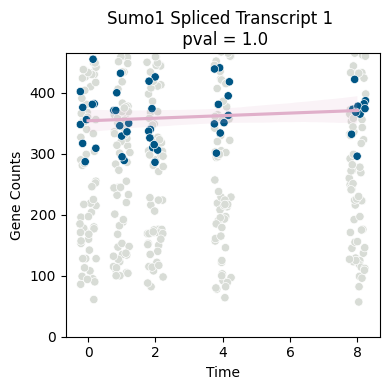

/tmp/ipykernel_2070132/3547436069.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df.loc[:,'jiggle_time'] = small_df.time + .25-.5*np.random.random(size = len(small_df.time.values))


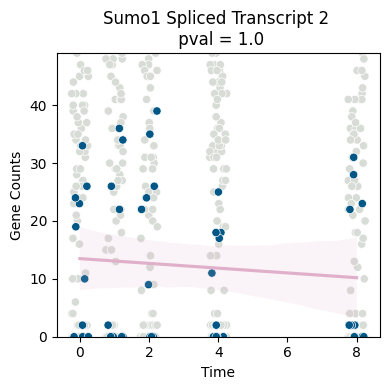

/tmp/ipykernel_2070132/3547436069.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df.loc[:,'jiggle_time'] = small_df.time + .25-.5*np.random.random(size = len(small_df.time.values))


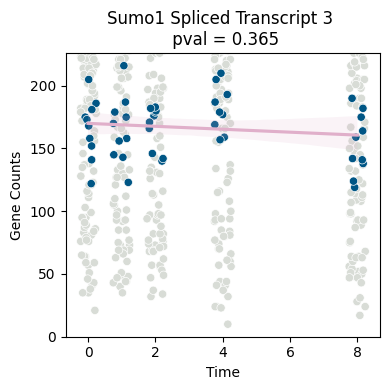

/tmp/ipykernel_2070132/3547436069.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df.loc[:,'jiggle_time'] = small_df.time + .25-.5*np.random.random(size = len(small_df.time.values))


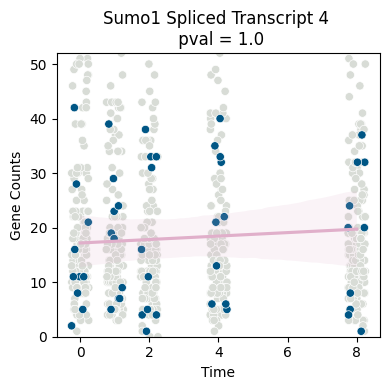

/tmp/ipykernel_2070132/3547436069.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df.loc[:,'jiggle_time'] = small_df.time + .25-.5*np.random.random(size = len(small_df.time.values))


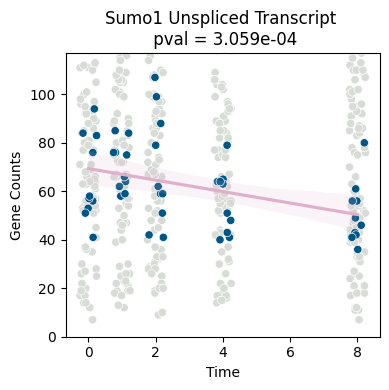

/tmp/ipykernel_2070132/3547436069.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df.loc[:,'jiggle_time'] = small_df.time + .25-.5*np.random.random(size = len(small_df.time.values))


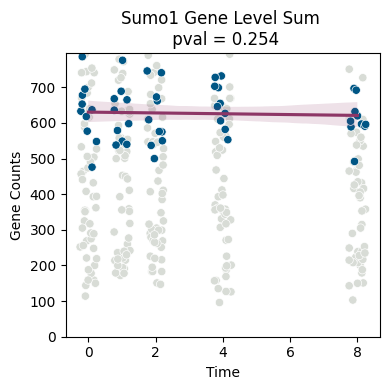

In [ ]:
axis_index = 0
axis_list = [[0, 100], [1000, 3000], [8000, 15000]]
for curr_goi in summary_df['Gene/Transcript'].unique():
    small_df = summary_df[summary_df['Gene/Transcript'] == curr_goi]
    small_df.loc[:,'tissue'] = small_df.tissue == toi
    small_df.loc[:,'tissue'] = [toi if x else 'Other' for x in small_df.tissue.values]
    small_df.loc[:,'jiggle_time'] = small_df.time + .25-.5*np.random.random(size = len(small_df.time.values))

    
    plt.figure(figsize=(4, 4))
    g = sns.scatterplot(
            data=small_df.sort_values('tissue',ascending=True), x='jiggle_time', y='gene_count',
        hue = 'tissue',
        palette = color_dict,
            )
    sns.regplot(
        data=small_df[small_df.tissue.isin([toi])], x='time', y='gene_count',
    color = color_dict[small_df.splice_type.values[0]],scatter=False
)
    plt.legend([],[], frameon=False)
    plt.xlabel('Time')
    plt.ylabel('Gene Counts')
    plt.ylim([0, small_df[small_df.tissue.isin([toi])].gene_count.max()+10])
    plt.title(f'{curr_goi}')
    plt.tight_layout()
    plt.savefig(f'figures_final/fig_2{'defghi'[axis_index]}.png')
    axis_index+=1
    plt.show()
    plt.close()